### Load Data

In [1]:
import codecs
import nltk
import re
from nltk.stem import WordNetLemmatizer

cn_stopwords = set([ line.rstrip() for line in codecs.open('dataset/cn_stop_words.txt',"r", encoding="utf-8")])
en_stopwords = set([ line.rstrip() for line in codecs.open('dataset/en_stop_words.txt',"r", encoding="utf-8")])
lemmatizer = WordNetLemmatizer()

def remove_new_line(text):
    text = text.replace('\n', '')
    text = ' '.join(text.split())
    return text

def lemmatize(review):
    review = re.sub(r'[^a-zA-Z\s]', '', review)
    review = review.lower()
    review = nltk.word_tokenize(review)
    corpus = []
    for y in review:
        if y not in en_stopwords:
            corpus.append(lemmatizer.lemmatize(y))
    return ' '.join(corpus)

In [2]:
import pandas as pd
import numpy as np

df_attributes = pd.read_csv('dataset/stories_attributes.csv')
df_text = pd.read_csv('dataset/stories_in_text.csv')
df_translated = pd.read_csv('dataset/stories_translated.csv')

df = pd.merge(df_attributes, df_text, on=['filename', 'Language'])
df = pd.merge(df, df_translated, on=['filename', 'Language'])

# 0 = truth, 1 = deceptive
df['label'] = np.where(df['Story_type'] == 'Deceptive Story', 1, 0)
df['idx'] = range(len(df))
df['text_line'] = df['text'].apply(remove_new_line)
df['text_lemma'] = df['text_english'].apply(lemmatize)
df = df.drop(columns=['Story_type'])
df

,filename,Language,text,text_english,label,idx,text_line,text_lemma
0,00001.wav,Chinese,2021年的冬天，\n我回了一趟老家探望外婆，\n那年他身体不好，\n住在离村子不远的小镇医...,"In the winter of 2021, I went back to my homet...",0,0,2021年的冬天，我回了一趟老家探望外婆，那年他身体不好，住在离村子不远的小镇医院里，冬天的...,winter hometown visit grandmother good health ...
1,00002.wav,Chinese,2022年暑假我终于实现了去云南旅行的梦想。\n云南的美景和独特文化一直是我向往的，\n而这...,I finally realized my dream of traveling to Yu...,0,1,2022年暑假我终于实现了去云南旅行的梦想。云南的美景和独特文化一直是我向往的，而这次旅行让...,finally realized dream traveling yunnan summer...
2,00003.wav,Chinese,这是我的故事。\n我的旅程从据著名的故宫开始，它是世界上最大保存\n保存最完整的皇宫建筑群。...,This is my story. My journey begins with the f...,0,2,这是我的故事。我的旅程从据著名的故宫开始，它是世界上最大保存保存最完整的皇宫建筑群。当我踏入...,story journey famous forbidden city largest pr...
3,00004.wav,Chinese,在2020年呢我报名参加了学校组织的美国研学活动，\n我跟我的另外两个同学以及许多老师同学们...,"In 2020, I registered for the school's organiz...",0,3,在2020年呢我报名参加了学校组织的美国研学活动，我跟我的另外两个同学以及许多老师同学们一起...,registered school organized study tour united ...
4,00005.wav,Chinese,今天我想和大家分享我去年的陕西之旅，\n当我踏上这片古老的土地，心中充满了期待与敬畏。\n我...,"Today, I would like to share with you my trip ...",0,4,今天我想和大家分享我去年的陕西之旅，当我踏上这片古老的土地，心中充满了期待与敬畏。我在陕西之...,today share trip shaanxi year stepped ancient ...
...,...,...,...,...,...,...,...,...
95,00096.wav,English,Uh. \nW is a\n uh my friends and I decided to...,Uh. W is a uh my friends and I decided to go h...,0,95,Uh. W is a uh my friends and I decided to go h...,uh uh friend decided hiking life true uh left ...
96,00097.wav,Chinese,上周\n我前往宜家\n孤儿院\n去看望我大学时期志愿服务时认识的小男孩，\n浩浩，\n那是一...,"Last week, I went to IKEA Orphanage to visit t...",1,96,上周我前往宜家孤儿院去看望我大学时期志愿服务时认识的小男孩，浩浩，那是一个安静的冬日午后阳光...,week ikea orphanage visit boy met college volu...
97,00098.wav,Chinese,呃上个周末我和我的朋友们准备去参加一场徒步旅行，\n然后目标是一片森林，\n那天的天气比较阴...,"Last weekend, my friends and I were planning t...",0,97,呃上个周末我和我的朋友们准备去参加一场徒步旅行，然后目标是一片森林，那天的天气比较阴沉，并且...,weekend friend planning participate hiking tri...
98,00099.wav,Chinese,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，\n我们都挺喜欢艺术的，所以就提前计...,"Ah, once in a while, my friends and I went to ...",1,98,啊一次有一次吧我和我的几个朋友去参加一个周末的艺术展览，我们都挺喜欢艺术的，所以就提前计划好...,friend attend weekend art exhibition love art ...


### Features from Text

In [3]:
def count_modal_particles(text):
    particles = [
        '啊', '呀', '啦', '吧', '呢', '嘛', '呗', '么', '噢', '呃', '额', '唔', '嗯',
        ' uh ', 'uh,', '\nuh ', 'uh.', ' oh ', 'oh,', '\noh ', 'oh.', ' um ', 'um,', '\num ', 'um.', ' ah ', 'ah,', '\nah ', 'ah.',
    ]
    count = 0
    for particle in particles:
        count += len(re.findall(particle, text.lower()))
    return count

def count_new_line(text):
    return len(re.findall('\n', text))

def calculate_repetition(text):
    words = [w for w in text.split() if w]
    if not words:
        return 0
        
    word_counts = {}
    for word in words:
        word_counts[word] = word_counts.get(word, 0) + 1
    repeated_words = sum(count - 1 for count in word_counts.values())
    repetition_ratio = repeated_words / len(words)
    
    return repetition_ratio

def count_stop_words(lang, text):
    stopwords = cn_stopwords if lang == 'Chinese' else en_stopwords
    count = 0
    for word in stopwords:
        pattern = r'\b' + re.escape(word) + r'\b'
        try:
            matches = re.findall(pattern, text.lower())
            count += len(matches)
        except re.error:
            continue
    return count

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Basic Information
feats = {
    'is_cn': df['Language'] == 'Chinese', 
    'modal_particles': df['text'].apply(count_modal_particles),
    'new_line': df['text'].apply(count_new_line),
    'repetition': df['text_line'].apply(calculate_repetition),
    'stop_words': [count_stop_words(row['Language'], row['text_line']) 
                  for _, row in df.iterrows()],
    'length_en': df['text_english'].apply(len),
    'word_count_lemma': df['text_lemma'].apply(lambda x: x.split()) \
                        .apply(len).apply(lambda x: x+1),
    'word_richness': df['text_english'].apply(lambda x: len(set(x)) / len(x)),
    'sentence_count': df['text_english'].apply(lambda x: x.count('.') + x.count('!') + x.count('?')),
}

# TF-IDF Related Features
tfidf_en = TfidfVectorizer(
    max_features=100,
    ngram_range=(1, 3),
    stop_words='english'
)
tfidf_matrix_en = tfidf_en.fit_transform(df['text_lemma'])

feats['tfidf_vec_len'] = pd.Series([len(x.indices) for x in tfidf_matrix_en])
feats['tfidf_mean'] = pd.Series(np.array(tfidf_matrix_en.mean(axis=1)).flatten())
feats['tfidf_std'] =  pd.Series([np.std(x.data) for x in tfidf_matrix_en])

for i in range(100):
    feats[f'tfidf_{i}'] = pd.Series(tfidf_matrix_en.toarray()[i])

df_feats = pd.DataFrame(feats)
df_feats

,is_cn,modal_particles,new_line,repetition,stop_words,length_en,word_count_lemma,word_richness,sentence_count,tfidf_vec_len,...,tfidf_90,tfidf_91,tfidf_92,tfidf_93,tfidf_94,tfidf_95,tfidf_96,tfidf_97,tfidf_98,tfidf_99
0,True,2,44,0.000000,39,1730,116,0.023699,19,30,...,0.0,0.000000,0.038413,0.000000,0.118715,0.000000,0.108480,0.0,0.000000,0.000000
1,True,0,29,0.000000,36,1898,153,0.020548,20,28,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.112164,0.0,0.000000,0.000000
2,True,0,33,0.000000,38,2158,173,0.021779,20,24,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.054876
3,True,6,43,0.000000,44,2061,146,0.025230,26,25,...,0.0,0.238013,0.092651,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.069394
4,True,0,33,0.000000,31,1701,139,0.026455,15,16,...,0.0,0.000000,0.067137,0.086781,0.000000,0.088484,0.000000,0.0,0.000000,0.150855
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,19,42,0.373786,142,996,70,0.037149,24,16,...,0.0,0.000000,0.041894,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
96,True,1,84,0.000000,53,1844,137,0.023861,24,23,...,0.0,0.000000,0.000000,0.000000,0.143169,0.000000,0.261651,0.0,0.000000,0.138789
97,True,13,35,0.000000,33,1433,79,0.028611,15,15,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.175498
98,True,9,29,0.000000,26,1514,103,0.025099,13,17,...,0.0,0.000000,0.000000,0.000000,0.120691,0.000000,0.000000,0.0,0.211061,0.000000


### Features from Audio

In [5]:
from tqdm.notebook import tqdm
import torchaudio

list_waveform = []
list_sample_rate = []
for i in tqdm(range(len(df))):
    wav_file = f'dataset/stories/{df.iloc[i]["filename"]}'
    waveform, sample_rate = torchaudio.load(wav_file)
    list_waveform.append(waveform)
    list_sample_rate.append(sample_rate)

  0%|          | 0/100 [00:00<?, ?it/s]

In [9]:
from feats.audio import get_silence_indices

silence_feats = []
for i in tqdm(range(len(df))):
    # Get Silence Indices
    silence_indices = get_silence_indices(list_waveform[i][0].numpy(), list_sample_rate[i])
    silence_feats.append([])

    # Silence Features
    silence_feats[i].append(len(silence_indices))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]))

    # Silence Features (Length Balanced)
    silence_feats[i].append(len(silence_indices) / len(list_waveform[i][0]))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]) / len(list_waveform[i][0]))

    # Silence Features (Language Balanced)
    # Means: If Chinese, do *2, as for students, Chinese is more fluent
    silence_feats[i].append(len(silence_indices) * (2 if df.iloc[i]['Language'] == 'Chinese' else 1))
    silence_feats[i].append(sum([end - start for start, end in silence_indices]) * (2 if df.iloc[i]['Language'] == 'Chinese' else 1))

feats['silence_count'] = [x[0] for x in silence_feats]
feats['silence_duration'] = [x[1] for x in silence_feats]
feats['silence_count__length'] = [x[2] for x in silence_feats]
feats['silence_duration__length'] = [x[3] for x in silence_feats]
feats['silence_count__lang'] = [x[4] for x in silence_feats]
feats['silence_duration__lang'] = [x[5] for x in silence_feats]

  0%|          | 0/100 [00:00<?, ?it/s]

In [10]:
more_audio_feats = []
for i in tqdm(range(len(df))):
    wf_np = list_waveform[i][0].numpy()
    energy = np.sum(np.square(wf_np))
    zero_crossings = np.sum(np.diff(np.signbit(wf_np)))
    more_audio_feats.append([energy, zero_crossings])
more_audio_feats = np.array(more_audio_feats)

feats['voice_energy'] = more_audio_feats[:,0]
feats['voice_zero_crossings'] = more_audio_feats[:,1]

  0%|          | 0/100 [00:00<?, ?it/s]

In [11]:
from tqdm.notebook import tqdm
import numpy as np

from feats.audio import get_f_bank_feats

f_audio_feats = []
for i in tqdm(range(len(df))):
    # Get F_Banks Results
    f_banks = np.asarray(get_f_bank_feats(list_waveform[i][0], list_sample_rate[i]))
    # f_banks = librosa.feature.melspectrogram(y=np.asarray(list_waveform[i][0]), sr=list_sample_rate[i], n_mels=40).T

    # Calculate F_Banks Statistics
    f_means = np.mean(f_banks, axis=0)  # (40,)
    f_all_max = np.max(f_banks, axis=0)  # (40,)
    f_all_min = np.min(f_banks, axis=0)  # (40,)
    f_stats = np.concatenate([
        f_means, f_all_max, f_all_min
    ])
    f_audio_feats.append(f_stats)

f_audio_feats = np.array(f_audio_feats)
feat_names = []
for stat in ['mean', 'max', 'min']:
    for i in range(40):
        feat_names.append(f'f_bank_{stat}_{i}')

for i, name in enumerate(feat_names):
    feats[name] = f_audio_feats[:, i]

df_feats = pd.DataFrame(feats)
df_feats

  0%|          | 0/100 [00:00<?, ?it/s]

,is_cn,modal_particles,new_line,repetition,stop_words,length_en,word_count_lemma,word_richness,sentence_count,tfidf_vec_len,...,f_bank_min_30,f_bank_min_31,f_bank_min_32,f_bank_min_33,f_bank_min_34,f_bank_min_35,f_bank_min_36,f_bank_min_37,f_bank_min_38,f_bank_min_39
0,True,2,44,0.000000,39,1730,116,0.023699,19,30,...,-12.651694,-12.503399,-12.590755,-11.775176,-11.508147,-11.246720,-10.893195,-10.535343,-10.292615,-10.631175
1,True,0,29,0.000000,36,1898,153,0.020548,20,28,...,-13.569064,-12.389540,-11.697145,-11.324645,-11.532026,-11.258627,-12.141105,-14.172897,-14.942272,-15.357892
2,True,0,33,0.000000,38,2158,173,0.021779,20,24,...,-15.622457,-15.197051,-15.086365,-14.994941,-14.642530,-14.364624,-13.973715,-14.193736,-13.854203,-13.514560
3,True,6,43,0.000000,44,2061,146,0.025230,26,25,...,-15.036171,-15.391803,-15.108377,-14.685904,-14.608970,-14.444119,-14.246261,-13.865327,-13.662978,-13.567836
4,True,0,33,0.000000,31,1701,139,0.026455,15,16,...,-12.155800,-12.282447,-11.745874,-11.336093,-11.355878,-10.746713,-10.516589,-10.324493,-10.271720,-10.323216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,False,19,42,0.373786,142,996,70,0.037149,24,16,...,-15.389595,-15.429474,-15.200507,-14.604245,-14.403071,-14.429158,-13.865187,-13.907432,-14.386015,-14.591955
96,True,1,84,0.000000,53,1844,137,0.023861,24,23,...,-15.648572,-15.457879,-15.118999,-14.789861,-14.596526,-14.431129,-14.217156,-14.117102,-14.373189,-14.782300
97,True,13,35,0.000000,33,1433,79,0.028611,15,15,...,-15.673203,-15.451294,-14.987769,-14.702625,-14.606583,-14.037570,-13.957192,-13.999018,-14.339170,-14.603734
98,True,9,29,0.000000,26,1514,103,0.025099,13,17,...,-15.446148,-15.240155,-15.006281,-14.849434,-14.776314,-14.143353,-13.926983,-13.881326,-14.300455,-14.641323


### Do Boosting

In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import classification_report, roc_curve, auc
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

def fit(use_stacking, use_xgboost, use_lightgbm, use_catboost, use_naivebayes, use_knn_model, n_jobs=8):
    X = df_feats
    y = df['label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.21, random_state=42, stratify=y, shuffle=True,
    )

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    base_models = []
    if use_xgboost:
        base_models.append(('xgboost', XGBClassifier(
            random_state=0,
            n_jobs=n_jobs,
            eval_metric='mlogloss'
        )))
    if use_lightgbm:
        base_models.append(('lightgbm', LGBMClassifier(
            random_state=0,
            n_jobs=n_jobs,
            verbose=-1
        )))
    if use_catboost:
        base_models.append(('catboost', CatBoostClassifier(
            random_state=0,
            thread_count=n_jobs,
            verbose=False
        )))
    if use_naivebayes:
        base_models.append(('naivebayes', GaussianNB()))
    if use_knn_model:
        base_models.append(('knn_model', KNeighborsClassifier(
            n_neighbors=7, # 7 better than 3, 5, 9 and 11
            n_jobs=n_jobs,
        )))

    if use_stacking and len(base_models) > 1:
        print(f"Stacking [{', '.join([name for name, _ in base_models])}]")
        stacking_clf = StackingClassifier(
            estimators=base_models,
            final_estimator=LogisticRegression(random_state=0, n_jobs=n_jobs,),
            passthrough=False,
            cv=5,
            n_jobs=n_jobs,
        )
        clf = OneVsRestClassifier(stacking_clf, n_jobs=n_jobs,)
    else:
        print(f"Using {base_models[0][0]}")
        clf = OneVsRestClassifier(base_models[0][1], n_jobs=n_jobs,)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    print("Report:")
    print(classification_report(y_test, y_pred))

    y_pred_proba = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    print("ROC AUC:", f'{roc_auc:.2f}')

    return clf

use_stacking = True
clf = fit(
    use_stacking=use_stacking,
    use_xgboost=False, use_lightgbm=False, use_catboost=True,
    use_naivebayes=True, use_knn_model=True,
)

Stacking [catboost, naivebayes, knn_model]
Report:
              precision    recall  f1-score   support

           0       0.75      0.55      0.63        11
           1       0.62      0.80      0.70        10

    accuracy                           0.67        21
   macro avg       0.68      0.67      0.66        21
weighted avg       0.69      0.67      0.66        21

ROC AUC: 0.60


### Result Analysis

In [29]:
if not use_stacking:
    feature_importance = clf.estimators_[0].feature_importances_
    feature_names = df_feats.columns

    df_importance = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    }).sort_values('Importance', ascending=False)

    print(df_importance.to_string(index=False))

                 Feature  Importance
           f_bank_max_19    3.469610
                tfidf_87    2.611241
                tfidf_94    2.211182
           f_bank_min_38    1.886957
                tfidf_96    1.818164
        word_count_lemma    1.705545
           f_bank_min_37    1.638103
               tfidf_std    1.584387
           f_bank_max_29    1.427630
                tfidf_58    1.364338
               length_en    1.107262
                tfidf_12    1.088263
          sentence_count    1.071550
           f_bank_max_28    1.020659
            f_bank_min_4    0.950734
   silence_count__length    0.939993
            f_bank_min_9    0.916703
        silence_duration    0.859321
          f_bank_mean_25    0.832835
                tfidf_86    0.829309
  silence_duration__lang    0.789480
           f_bank_max_23    0.780329
                tfidf_56    0.754150
           f_bank_max_20    0.747024
          f_bank_mean_27    0.731565
     silence_count__lang    0.700078
 

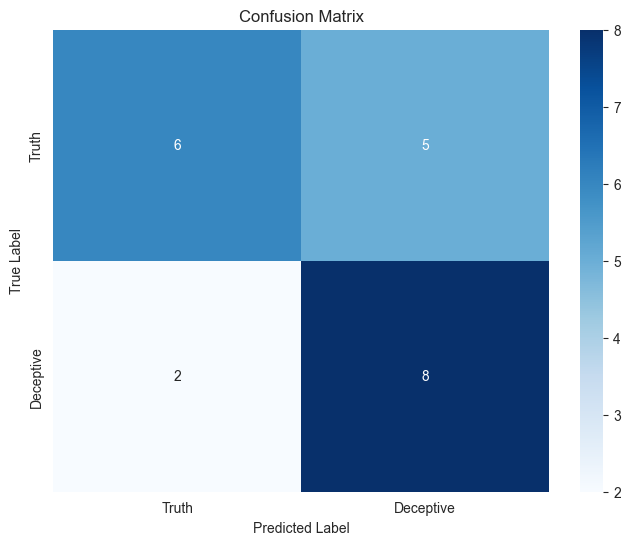

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Truth', 'Deceptive'],
            yticklabels=['Truth', 'Deceptive'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()